In [1]:
# !pip install pycaret
from pycaret.datasets import get_data
from pycaret.clustering import *
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
# !pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import  fcluster


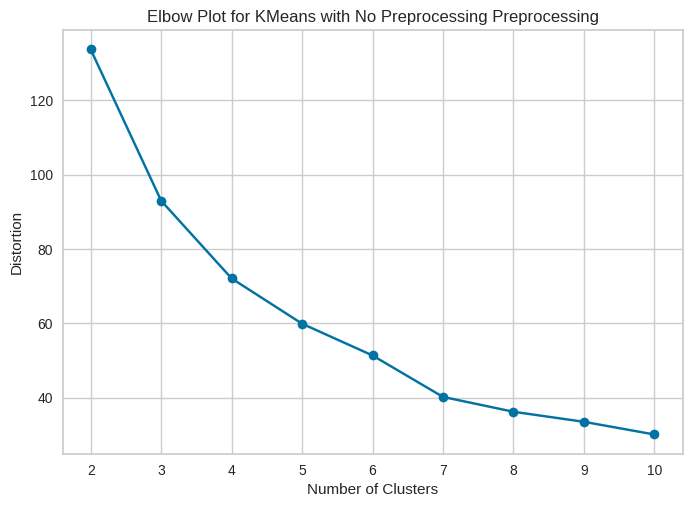

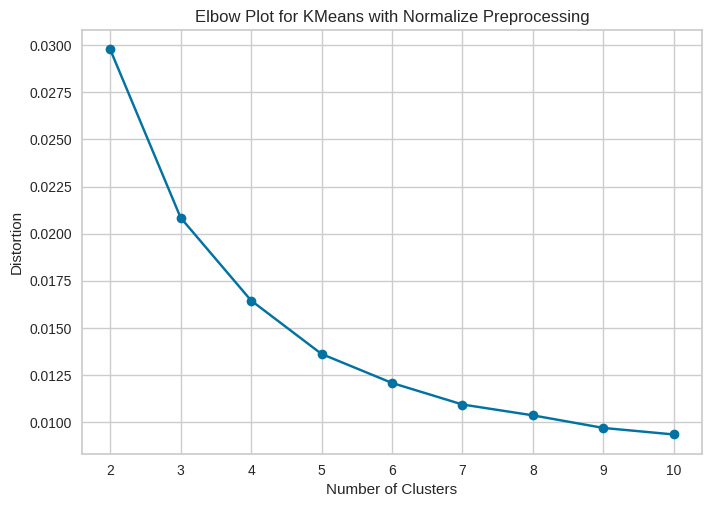

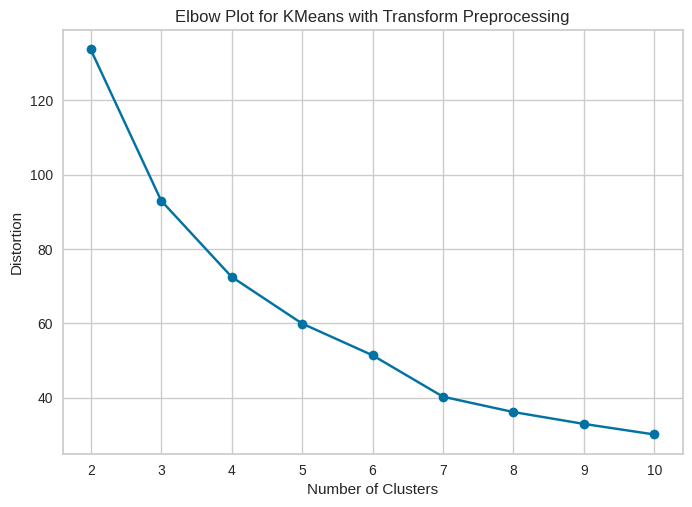

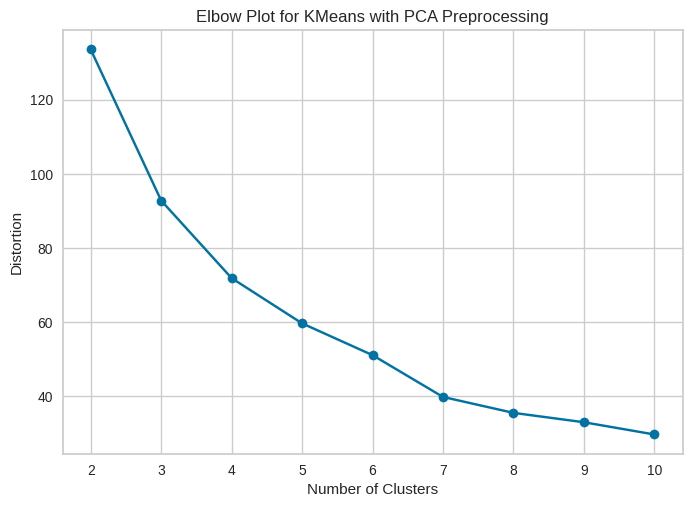

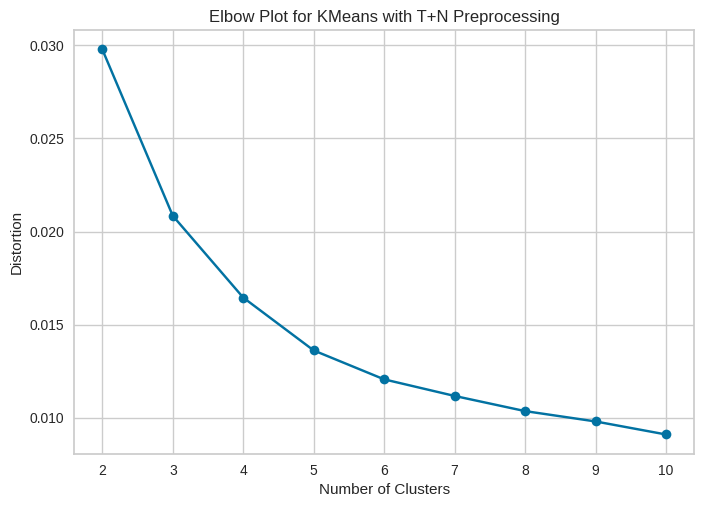

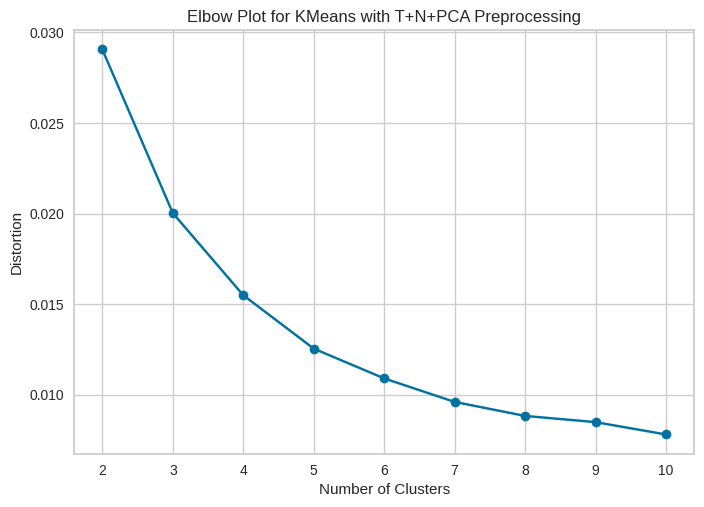

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

# Load wine dataset
wine = load_wine()
X = wine.data

# Define preprocessing approaches
preprocessing = {
    'No Preprocessing': lambda x: x,
    'Normalize': normalize,
    'Transform': lambda x: x,  # Replace with your own transformation function
    'PCA': lambda x: PCA(n_components=2).fit_transform(x),
    'T+N': lambda x: normalize(x),
    'T+N+PCA': lambda x: PCA(n_components=2).fit_transform(normalize(x))
}

# Define the number of clusters for the elbow plot
clusters_range = range(2, 11)

# Generate elbow plots for KMeans, Hierarchical, and Birch
for model_name, model in [('KMeans', KMeans()), ('Hierarchical', linkage), ('Birch', Birch())]:
    for preprocess_column, preprocess_func in preprocessing.items():
        X_preprocessed = preprocess_func(X)

        if model_name == 'KMeans':
            distortions = []
            for cluster in clusters_range:
                kmeans = KMeans(n_clusters=cluster)
                kmeans.fit(X_preprocessed)
                distortions.append(sum(np.min(cdist(X_preprocessed, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_preprocessed.shape[0])

            # Plot the elbow plot for KMeans
            plt.plot(clusters_range, distortions, marker='o')
            plt.title(f'Elbow Plot for {model_name} with {preprocess_column} Preprocessing')
            plt.xlabel('Number of Clusters')
            plt.ylabel('Distortion')
            plt.show()



In [4]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Import necessary libraries
import pandas as pd
from sklearn.datasets import load_wine
from pycaret.clustering import *
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load wine dataset
wine = load_wine()
data = pd.DataFrame(wine.data, columns=wine.feature_names)

# Define preprocessing approaches using PyCaret
preprocessing_pycaret = {
    'No Preprocessing': None,
    'Normalize': 'normalize',
    'Transform': 'transformation',
    'PCA': 'pca',
    'T+N': ['normalize', 'transformation'],
    'T+N+PCA': ['normalize', 'transformation', 'pca']
}

# Define clustering algorithms using PyCaret with corresponding model names
clustering_algorithms = {
    'kmeans': 'K-Means',
    'hclust': 'Hierarchical',
    'birch': 'Birch'
}

# Create DataFrames to store the results for each algorithm
index = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']
columns = pd.MultiIndex.from_product([['No Preprocessing', 'Normalize', 'Transform', 'PCA', 'T+N', 'T+N+PCA'], ['c=3', 'c=4', 'c=5']], names=['Preprocessing', 'Clusters'])
results_df = pd.DataFrame(index=index, columns=columns)

# Perform clustering for each combination of preprocessing, algorithm, and clusters using PyCaret
for preprocess_column, preprocess_steps in preprocessing_pycaret.items():
    for algorithm, model_name in clustering_algorithms.items():
        print(f"Model name: {model_name} and Preprocessing used: {preprocess_column}")
        for c in columns.get_level_values('Clusters').unique():
            print(c)
            # Setup PyCaret clustering
            setup(data, normalize=preprocess_steps, transformation=preprocess_steps, verbose=False, pca=preprocess_steps)

            # Create and evaluate the clustering model

            model = create_model(algorithm, num_clusters=int(c[-1]))
            prediction = assign_model(model)

            # Calculate clustering metrics
            labels_column = 'Cluster'  # Adjusted labels column name
            silhouette_score_val = silhouette_score(data, prediction[labels_column])
            calinski_harabasz_index_val = calinski_harabasz_score(data, prediction[labels_column])
            davies_bouldin_index_val = davies_bouldin_score(data, prediction[labels_column])

            # Update the results DataFrame with model name
            results_df.loc[:, (f'{model_name} - {preprocess_column}', c)] = [silhouette_score_val, calinski_harabasz_index_val, davies_bouldin_index_val]



Model name: K-Means and Preprocessing used: No Preprocessing
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5711,561.8156,0.5342,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5606,707.3763,0.5445,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5490,787.0469,0.5450,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: No Preprocessing
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5645,552.8518,0.5357,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5607,670.6260,0.5536,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5075,684.2226,0.5513,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: No Preprocessing
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5645,552.8518,0.5357,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5607,670.6260,0.5536,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5075,684.2226,0.5513,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: Normalize
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3013,73.1201,1.3609,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2764,57.3189,1.7684,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2598,48.3994,1.7756,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: Normalize
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2898,68.9693,1.3854,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2518,53.1404,1.7041,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2295,44.8019,1.8092,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: Normalize
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2898,68.9693,1.3854,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2518,53.1404,1.7041,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2295,44.8019,1.8092,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: Transform
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3013,73.1201,1.3609,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2726,57.3923,1.7604,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1849,47.3784,1.9830,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: Transform
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2898,68.9693,1.3854,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2518,53.1404,1.7041,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2295,44.8019,1.8092,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: Transform
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2898,68.9693,1.3854,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2518,53.1404,1.7041,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2295,44.8019,1.8092,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3013,73.1201,1.3609,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2758,57.0408,1.8022,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1919,47.0269,2.0028,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2898,68.9693,1.3854,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2518,53.1404,1.7041,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2295,44.8019,1.8092,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2898,68.9693,1.3854,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2518,53.1404,1.7041,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2295,44.8019,1.8092,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: T+N
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3013,73.1201,1.3609,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2854,57.3555,1.6374,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2515,48.2513,1.7533,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: T+N
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2898,68.9693,1.3854,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2518,53.1404,1.7041,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2295,44.8019,1.8092,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: T+N
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2898,68.9693,1.3854,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2518,53.1404,1.7041,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2295,44.8019,1.8092,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: K-Means and Preprocessing used: T+N+PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3013,73.1201,1.3609,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2751,57.4408,1.7478,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2564,48.5131,1.7255,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Hierarchical and Preprocessing used: T+N+PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2898,68.9693,1.3854,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2518,53.1404,1.7041,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2295,44.8019,1.8092,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Model name: Birch and Preprocessing used: T+N+PCA
c=3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2898,68.9693,1.3854,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=4


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2518,53.1404,1.7041,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

c=5


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2295,44.8019,1.8092,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
results_df = results_df.dropna(axis=1)
display(results_df)
# Save the results to a CSV file
results_df.to_csv('pycaret_results.csv', index=True)

Preprocessing     K-Means - No Preprocessing                          \
Clusters                                 c=3         c=4         c=5   
Silhouette                          0.571138    0.560594    0.548999   
Calinski-Harabasz                 561.815658  707.376327  787.046922   
Davies-Bouldin                      0.534243    0.544544    0.545047   

Preprocessing     Hierarchical - No Preprocessing                          \
Clusters                                      c=3         c=4         c=5   
Silhouette                               0.564480    0.560673    0.507484   
Calinski-Harabasz                      552.851712  670.625991  684.222613   
Davies-Bouldin                           0.535734    0.553574    0.551315   

Preprocessing     Birch - No Preprocessing                          \
Clusters                               c=3         c=4         c=5   
Silhouette                        0.564480    0.560673    0.507484   
Calinski-Harabasz               552.851712  670.625991  684.222613   
Davies-Bouldin                    0.535734    0.553574    0.551315   

Preprocessing     K-Means - Normalize  ... Birch - T+N K-Means - T+N+PCA  \
Clusters                          c=3  ...         c=5               c=3   
Silhouette                   0.199192  ...    0.023634          0.199192   
Calinski-Harabasz          203.078623  ...   85.760985        203.078623   
Davies-Bouldin               1.399862  ...    7.789415          1.399862   

Preprocessing                             Hierarchical - T+N+PCA              \
Clusters                  c=4         c=5                    c=3         c=4   
Silhouette           0.142422    0.101874               0.189581    0.108347   
Calinski-Harabasz  147.204971  110.600205             172.529209  114.933347   
Davies-Bouldin       2.921266    5.438279               1.542390    3.221529   

Preprocessing                Birch - T+N+PCA                         
Clusters                 c=5             c=3         c=4        c=5  
Silhouette          0.023634        0.189581    0.108347   0.023634  
Calinski-Harabasz  85.760985      172.529209  114.933347  85.760985  
Davies-Bouldin      7.789415        1.542390    3.221529   7.789415  

[3 rows x 54 columns]